# OC precinct presidential votes

#### Load Python tools and Jupyter config

In [1]:
import json
import requests
import pandas as pd
import jupyter_black
import altair as alt
import geopandas as gpd

In [2]:
jupyter_black.load()
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = None

In [3]:
today = pd.Timestamp("today").strftime("%Y%m%d")

---

## Read

#### Tab-delimitted file with OC primary election results by precinct

In [4]:
src = pd.read_csv(
    "data/raw/results-primary-final.csv",
    sep=r"\t",
    # quotechar='"',
    encoding="utf-8",
    engine="python",
)

#### Clean up the column names

In [5]:
src.columns = (
    src.columns.str.lower()
    .str.replace(" ", "_")
    .str.replace(".", "")
    .str.replace("/", "_")
)

#### Just the presidential candidates

In [6]:
df = src.query('contest_title=="PRESIDENT OF THE UNITED STATES"')[
    [
        "precinct",
        "precinct_id",
        "contest_title",
        "contest_party",
        "choice_name",
        "total_votes",
        "ballots_cast",
    ]
].copy()

#### The dataframe is long. Pivot the table wide so each candidate get a column and filter out (~700 precincts with note ballots cast)

In [7]:
df_wide = (
    df.pivot_table(
        index=["precinct", "precinct_id", "contest_title", "ballots_cast"],
        columns="choice_name",
        values="total_votes",
    )
    .reset_index()
    .copy()
).query("ballots_cast > 0")

#### Clean up column names

In [8]:
df_wide.columns = (
    df_wide.columns.str.lower()
    .str.replace(" ", "_")
    .str.replace(".", "")
    .str.replace("/", "_")
    .str.replace("-", "_")
)

#### Candidate lists

In [9]:
all_cand_cols = [
    "andrew_george_rummel",
    "armando_mando_perez_serrato",
    "asa_hutchinson",
    "charles_ballay",
    "chase_oliver",
    "chris_christie",
    "claudia_de_la_cruz",
    "cornel_west",
    "david_stuckenberg",
    "dean_phillips",
    "douglas_groves",
    "eban_cambridge",
    "gabriel_cornejo",
    "hugo_c_aguilar",
    "james_bradley",
    "james_mark_merts",
    "jasmine_sherman",
    "marianne_williamson",
    "nikki_haley",
    "president_cristina_nicole_grappo",
    "president_r_boddie",
    "rachel_swift",
    "reed_michaelsen",
    "richard_gutierrez",
    "ron_desantis",
    "ryan_l_binkley",
    "ryan_stephen_ehrenreich",
    "stephen_p_lyons",
    "vivek_ramaswamy",
    "wayne_anthony_pope_sr",
    "willie_felix_carter",
    "joseph_r_biden_jr",
    "donald_j_trump",
]

#### Make sure the columns with votes get treated like numbers

In [10]:
df_wide[all_cand_cols] = df_wide[all_cand_cols].apply(pd.to_numeric, errors="coerce")

#### Count up all votes in presidential contest (not all ballots have a prez vote)

In [11]:
df_wide["all_votes"] = df_wide[all_cand_cols].sum(axis=1)

#### Just the major candidates

In [12]:
major_candidates = ["joseph_r_biden_jr", "donald_j_trump"]

#### Make a list of the candidates who aren't Biden or Trump

In [13]:
other_candidate_columns = [
    cand for cand in all_cand_cols if cand not in major_candidates
]

#### How many votes did the "other" candidates get

In [14]:
df_wide["other_candidates"] = df_wide[other_candidate_columns].sum(axis=1)

#### Find the maximum number of votes in each row

In [15]:
df_wide["winner_votes"] = df_wide[all_cand_cols].max(axis=1)

#### Function to determine the winner or 'tie'

In [16]:
def determine_winner(row):
    max_candidates = [col for col in all_cand_cols if row[col] == row["winner_votes"]]
    if len(max_candidates) == 1:
        return max_candidates[0]  # Return the single winner
    else:
        return "tie"  # More than one candidate received the max votes

#### Apply the function to determine 'winner' or 'tie'

In [17]:
df_wide["winner"] = df_wide.apply(determine_winner, axis=1)

#### How many precincts did candidates win?

In [18]:
df_wide["winner_name"] = df_wide["winner"].str.replace("_", " ").str.title()

In [19]:
winners = (
    df_wide.winner_name.value_counts()
    .reset_index()
    .rename(columns={"count": "precincts_won"})
)
winners

,winner_name,precincts_won
0,Donald J Trump,753
1,Joseph R Biden Jr,629
2,Tie,28
3,Nikki Haley,1


#### There were ties? Really? 

In [20]:
ties = df_wide.query('winner == "tie"')[
    [
        "precinct",
        "precinct_id",
        "donald_j_trump",
        "joseph_r_biden_jr",
        "other_candidates",
        "all_votes",
    ]
].copy()
ties.head()

choice_name,precinct,precinct_id,donald_j_trump,joseph_r_biden_jr,other_candidates,all_votes
13,2033,100104,119.0,119.0,43.0,281.0
27,2073,100118,131.0,131.0,43.0,305.0
52,2171,100147,155.0,155.0,67.0,377.0
72,2306,100168,8.0,8.0,2.0,18.0
101,2432,100198,149.0,149.0,52.0,350.0


#### Define a function to apply to each row that will determine the top 3 candidates

In [21]:
def top_candidates(row):
    # Sorts the row by descending vote count, selects the top 3 candidates
    top_candidates = row[all_cand_cols].sort_values(ascending=False).head(3)
    return pd.Series(
        [*top_candidates.index, *top_candidates],
        index=[
            "top_candidate_one",
            "top_candidate_two",
            "top_candidate_three",
            "top_candidate_one_votes",
            "top_candidate_two_votes",
            "top_candidate_three_votes",
        ],
    )

#### Apply the function across the dataframe rows and join the results as new columns in df_wide

In [22]:
top_candidates_df = df_wide.apply(top_candidates, axis=1)
df_wide = df_wide.join(top_candidates_df)

#### Calculate share of the vote

In [23]:
df_wide["trump_pct"] = ((df_wide["donald_j_trump"] / df_wide["all_votes"]) * 100).round(
    2
)
df_wide["biden_pct"] = (
    (df_wide["joseph_r_biden_jr"] / df_wide["all_votes"]) * 100
).round(2)
df_wide["other_pct"] = (
    (df_wide["other_candidates"] / df_wide["all_votes"]) * 100
).round(2)
df_wide["winning_pct"] = ((df_wide["winner_votes"] / df_wide["all_votes"]) * 100).round(
    2
)

In [24]:
df_wide["contest_title"] = (
    df_wide["contest_title"].str.replace(" OF THE UNITED STATES", "").str.title()
)

In [25]:
df_slim = df_wide[
    [
        "precinct",
        "precinct_id",
        "contest_title",
        "all_votes",
        "donald_j_trump",
        "joseph_r_biden_jr",
        "other_candidates",
        "trump_pct",
        "biden_pct",
        "other_pct",
        "winner_name",
        "winner_votes",
        "winning_pct",
        "top_candidate_one",
        "top_candidate_two",
        "top_candidate_three",
        "top_candidate_one_votes",
        "top_candidate_two_votes",
        "top_candidate_three_votes",
    ]
].copy()

In [26]:
df_slim["top_candidate_one"] = (
    df_slim["top_candidate_one"].str.replace("_", " ").str.title()
)
df_slim["top_candidate_two"] = (
    df_slim["top_candidate_two"].str.replace("_", " ").str.title()
)
df_slim["top_candidate_three"] = (
    df_slim["top_candidate_three"].str.replace("_", " ").str.title()
)

In [27]:
df_slim["top_candidate_one_pct"] = (
    (df_slim["top_candidate_one_votes"] / df_slim["all_votes"]) * 100
).round(2)
df_slim["top_candidate_two_pct"] = (
    (df_slim["top_candidate_two_votes"] / df_slim["all_votes"]) * 100
).round(2)
df_slim["top_candidate_three_pct"] = (
    (df_slim["top_candidate_three_votes"] / df_slim["all_votes"]) * 100
).round(2)

In [28]:
df_slim["precinct"] = df_slim["precinct"].astype(str).str.zfill(5)

In [29]:
df_slim.head()

,precinct,precinct_id,contest_title,all_votes,donald_j_trump,joseph_r_biden_jr,other_candidates,trump_pct,biden_pct,other_pct,winner_name,winner_votes,winning_pct,top_candidate_one,top_candidate_two,top_candidate_three,top_candidate_one_votes,top_candidate_two_votes,top_candidate_three_votes,top_candidate_one_pct,top_candidate_two_pct,top_candidate_three_pct
0,02001,100091,President,52.0,15.0,19.0,18.0,28.85,36.54,34.62,Joseph R Biden Jr,19.0,36.54,Joseph R Biden Jr,Donald J Trump,Marianne Williamson,19.0,15.0,10.0,36.54,28.85,19.23
1,02002,100092,President,24.0,7.0,13.0,4.0,29.17,54.17,16.67,Joseph R Biden Jr,13.0,54.17,Joseph R Biden Jr,Donald J Trump,Marianne Williamson,13.0,7.0,3.0,54.17,29.17,12.50
2,02008,100093,President,453.0,170.0,207.0,76.0,37.53,45.70,16.78,Joseph R Biden Jr,207.0,45.70,Joseph R Biden Jr,Donald J Trump,Marianne Williamson,207.0,170.0,23.0,45.70,37.53,5.08
3,02009,100094,President,432.0,149.0,215.0,68.0,34.49,49.77,15.74,Joseph R Biden Jr,215.0,49.77,Joseph R Biden Jr,Donald J Trump,Marianne Williamson,215.0,149.0,15.0,49.77,34.49,3.47
4,02011,100095,President,987.0,520.0,299.0,168.0,52.68,30.29,17.02,Donald J Trump,520.0,52.68,Donald J Trump,Joseph R Biden Jr,Nikki Haley,520.0,299.0,101.0,52.68,30.29,10.23


---

## Geography

#### OC precincts

In [30]:
precincts_gdf = gpd.read_file("data/raw/OC_Precinct_2024_final.json")

In [31]:
precincts_gdf.columns = precincts_gdf.columns.str.lower()

<Axes: >

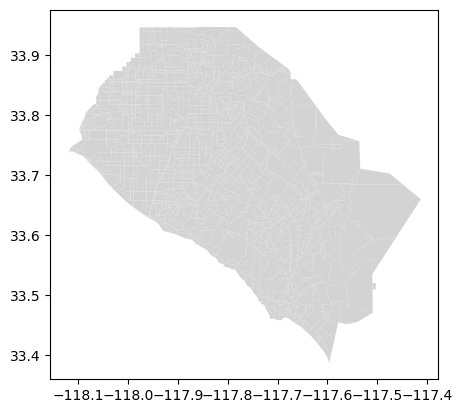

In [32]:
precincts_gdf.plot(color="lightgray")

---

## Merge

In [33]:
precincts_results = gpd.GeoDataFrame(pd.merge(precincts_gdf, df_slim, on="precinct"))

<Axes: >

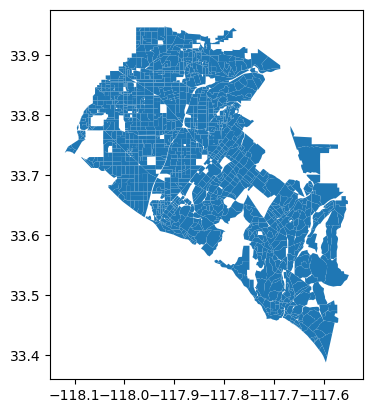

In [34]:
precincts_results.plot()

---

## Exports

#### JSON

In [35]:
df_slim.to_json(
    f"data/processed/oc_president_results_precincts.json",
    indent=4,
    orient="records",
)

#### CSV

In [36]:
df_slim.to_csv(f"data/processed/oc_president_results_precincts.csv", index=False)

#### GeoJSON

In [37]:
precincts_results.to_file(
    f"data/processed/oc_president_results_precincts.geojson",
    driver="GeoJSON",
)

In [ ]:
precincts_gdf.to_file(
    f"data/processed/oc_precincts.geojson",
    driver="GeoJSON",
)

In [40]:
!jupyter nbconvert --to script --no-prompt --output process_oc_precinct_results 01_oc.ipynb

[NbConvertApp] Converting notebook 01_oc.ipynb to script
[NbConvertApp] Writing 7908 bytes to process_oc_precinct_results.py
